In [1]:
# Импорт необходимых библиотек

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Фикс для графиков
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import heapq

from tensorflow import keras
from numpy.core.multiarray import dtype
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Input, Embedding
from keras.optimizers import RMSprop
from pylab import rcParams
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical
np.random.seed(42)

In [2]:
# Чтение файла

with open('homer-gnedich.txt', 'r', encoding='utf-8') as f:
    texts = f.read()
    texts = texts.replace('\ufeff', '')  # убираем первый невидимый символ

In [3]:
# Укажем сколько может быть слов в словаре, а также разобьем текст на отдельные слова

maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts([texts])
tokenizer.word_index

{'и': 1,
 'в': 2,
 'не': 3,
 'на': 4,
 'он': 5,
 'с': 6,
 'я': 7,
 'но': 8,
 'к': 9,
 'от': 10,
 'так': 11,
 'ты': 12,
 'как': 13,
 'его': 14,
 'их': 15,
 'из': 16,
 'же': 17,
 'что': 18,
 'у': 19,
 'за': 20,
 'ни': 21,
 'все': 22,
 'мне': 23,
 'по': 24,
 'если': 25,
 'меня': 26,
 'о': 27,
 'быстро': 28,
 'гектор': 29,
 'сам': 30,
 'а': 31,
 'тебя': 32,
 'под': 33,
 'сын': 34,
 'мы': 35,
 'они': 36,
 'бы': 37,
 'сына': 38,
 'коней': 39,
 'или': 40,
 'там': 41,
 'да': 42,
 'ему': 43,
 'сердце': 44,
 'пред': 45,
 'когда': 46,
 'всех': 47,
 'троян': 48,
 'ахеян': 49,
 'тебе': 50,
 'ж': 51,
 'данаев': 52,
 'мужей': 53,
 'ахиллес': 54,
 'ныне': 55,
 'им': 56,
 'него': 57,
 'был': 58,
 'между': 59,
 'меж': 60,
 'ним': 61,
 'вы': 62,
 'землю': 63,
 'то': 64,
 'говорил': 65,
 'еще': 66,
 'б': 67,
 'агамемнон': 68,
 'уже': 69,
 'рек': 70,
 'лишь': 71,
 'царь': 72,
 'скоро': 73,
 'мужа': 74,
 'где': 75,
 'нет': 76,
 'над': 77,
 'при': 78,
 'боги': 79,
 'прежде': 80,
 'зевс': 81,
 'трои': 82,
 'о

In [4]:
# Выведем некоторые слова и их частотность употребления

dist = list(tokenizer.word_counts.items())
print(dist[:10])

[('гнев', 43), ('богиня', 69), ('воспой', 1), ('ахиллеса', 59), ('пелеева', 18), ('сына', 257), ('грозный', 12), ('который', 129), ('ахеянам', 9), ('тысячи', 3)]


In [5]:
# Преобразуем текст в последовательность чисел в соответствие со словарем

data = tokenizer.texts_to_sequences([texts])
res = to_categorical(data[0], num_classes=maxWordsCount)
print(res.shape)

(109194, 10000)


In [6]:
data = tokenizer.texts_to_matrix('все') #последовательности токенов в OHE
print(data)
word_tokens = tokenizer.texts_to_matrix('все').argmax(axis=1)
word_tokens

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([   2,    6, 9687], dtype=int64)

In [7]:
# Настроим обучающую выборку

inp_words = 3
n = res.shape[0] - inp_words
n

109191

In [8]:
# Сформируем трехмерный тензор

X = np.array([res[i:i + inp_words, :] for i in range(n)])
Y = res[inp_words:]

In [18]:
# Построим RNN

model = Sequential()
model.add(Input((inp_words, maxWordsCount)))
model.add(SimpleRNN(units=128, input_shape=(inp_words,  maxWordsCount), return_sequences=True, recurrent_dropout=0.2))
model.add(Bidirectional(SimpleRNN(units=128, input_shape=(inp_words,  maxWordsCount), return_sequences=False, dropout=0.4, go_backwards=True, recurrent_dropout=0.2)))
model.add(Dense(maxWordsCount, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 3, 128)            1296512   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              65792     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 10000)             2570000   
                                                                 
Total params: 3,932,304
Trainable params: 3,932,304
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Скомпилируем модель и обучим модель

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(X, Y, validation_split=0.1, batch_size=512, epochs=25, shuffle=True ).history

Epoch 1/25
192/192 [==============================] - 22s 102ms/step - loss: 7.8693 - accuracy: 0.0531 - val_loss: 7.7138 - val_accuracy: 0.0578
Epoch 2/25
192/192 [==============================] - 20s 104ms/step - loss: 7.4590 - accuracy: 0.0547 - val_loss: 7.6985 - val_accuracy: 0.0588
Epoch 3/25
192/192 [==============================] - 20s 103ms/step - loss: 7.2085 - accuracy: 0.0581 - val_loss: 7.6172 - val_accuracy: 0.0578
Epoch 4/25
192/192 [==============================] - 19s 99ms/step - loss: 6.9001 - accuracy: 0.0655 - val_loss: 7.6409 - val_accuracy: 0.0547
Epoch 5/25
192/192 [==============================] - 19s 98ms/step - loss: 6.5740 - accuracy: 0.0767 - val_loss: 7.7186 - val_accuracy: 0.0527
Epoch 6/25
192/192 [==============================] - 18s 96ms/step - loss: 6.2554 - accuracy: 0.0903 - val_loss: 7.8442 - val_accuracy: 0.0493
Epoch 7/25
192/192 [==============================] - 18s 95ms/step - loss: 5.9499 - accuracy: 0.1075 - val_loss: 7.9809 - val_accura

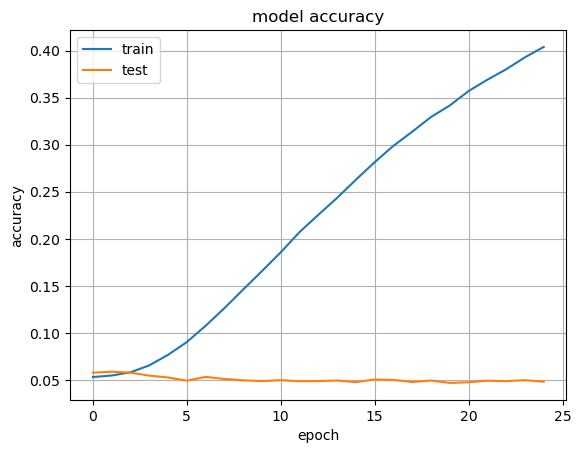

In [20]:
# Оценка и построение графиков
# График правильности модели

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best');
plt.grid()
plt.savefig("03.AccuracySimRNN.png")
plt.show()

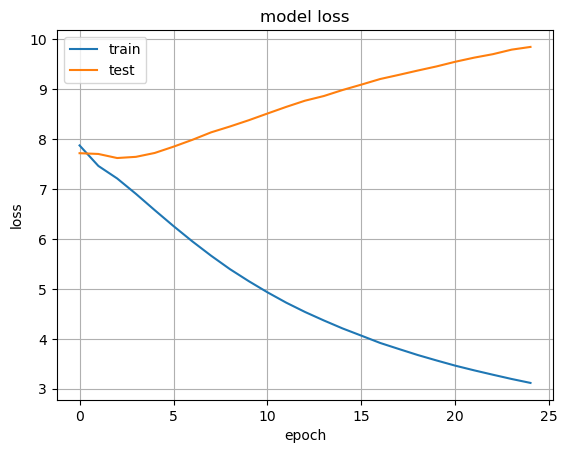

In [21]:
# График потерь

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');
plt.grid()
plt.savefig("04.LossSimRNN.png")
plt.show()

In [22]:
# Добавим функцию для построения фраз

def buildPhrase(texts, str_len=5):
    res = texts
    data = tokenizer.texts_to_sequences([texts])[0]
    for i in range(str_len):
        x = to_categorical(data[i: i + inp_words], num_classes=maxWordsCount)  # преобразуем в One-Hot-encoding
        inp = x.reshape(1, inp_words, maxWordsCount)

        pred = model.predict(inp)
        indx = pred.argmax(axis=1)[0]
        data.append(indx)

        res += " " + tokenizer.index_word[indx]  # дописываем строку

    return res

In [23]:
# Проверим модель используя примеры из датасета

# Язву на воинство злую навел; погибали народы
res = buildPhrase("язву на воинство")
print(res)
# Проверим модель

# Старец, он приходил к кораблям быстролетным ахейским
res = buildPhrase("он приходил к")
print(res)

1/1 [==============================] - 0s 20ms/step
язву на воинство злую навел я в казнь
1/1 [==============================] - 0s 20ms/step
он приходил к кораблям быстролетным ахеян темная ночь


In [24]:
# Проверим модель используя примеры не из датасета

# знаешь ли ты что такое горе
res = buildPhrase("знаешь ли ты")
print(res)
# Проверим модель ещё раз

# он приходил ко мне во снах
res = buildPhrase("он приходил ко")
print(res)

1/1 [==============================] - 0s 22ms/step
знаешь ли ты что мне вещаешь ты о
1/1 [==============================] - 0s 21ms/step
он приходил ко его меднобронных там между тем


Используем RNN со слоем Embedding

In [25]:
# Подготовим данные

data = tokenizer.texts_to_sequences([texts])
res = np.array( data[0] )

In [26]:
# Заново сформируем трехмерный тензор

X = np.array([res[i:i + inp_words] for i in range(n)])
Y = to_categorical(res[inp_words:], num_classes=maxWordsCount)

In [32]:
# Построим RNN c LSTM

model = Sequential()
model.add(Embedding(maxWordsCount, 256, input_length = inp_words))
model.add(LSTM(units=256, input_shape=(inp_words,  maxWordsCount), return_sequences=True, recurrent_dropout=0.2))
model.add(Bidirectional(LSTM(units=128, input_shape=(inp_words,  maxWordsCount), return_sequences=False, go_backwards=True, recurrent_dropout=0.2)))
model.add(Dense(maxWordsCount, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 256)            2560000   
                                                                 
 lstm_8 (LSTM)               (None, 3, 256)            525312    
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 10000)             2570000   
                                                                 
Total params: 6,049,552
Trainable params: 6,049,552
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Скомпилируем модель и обучим модель

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(X, Y, validation_split=0.1, batch_size=256, epochs=25, shuffle=True ).history
model.evaluate(X, Y)

Epoch 1/25
384/384 [==============================] - 35s 79ms/step - loss: 7.8371 - accuracy: 0.0542 - val_loss: 7.7168 - val_accuracy: 0.0578
Epoch 2/25
384/384 [==============================] - 28s 74ms/step - loss: 7.4918 - accuracy: 0.0547 - val_loss: 7.6713 - val_accuracy: 0.0574
Epoch 3/25
384/384 [==============================] - 32s 83ms/step - loss: 7.3036 - accuracy: 0.0568 - val_loss: 7.5909 - val_accuracy: 0.0595
Epoch 4/25
384/384 [==============================] - 29s 76ms/step - loss: 7.0681 - accuracy: 0.0589 - val_loss: 7.5169 - val_accuracy: 0.0593
Epoch 5/25
384/384 [==============================] - 30s 78ms/step - loss: 6.7755 - accuracy: 0.0641 - val_loss: 7.5511 - val_accuracy: 0.0583
Epoch 6/25
384/384 [==============================] - 30s 78ms/step - loss: 6.4649 - accuracy: 0.0724 - val_loss: 7.6475 - val_accuracy: 0.0588
Epoch 7/25
384/384 [==============================] - 30s 77ms/step - loss: 6.1400 - accuracy: 0.0824 - val_loss: 7.7581 - val_accuracy:

[2.4761252403259277, 0.6324788928031921]

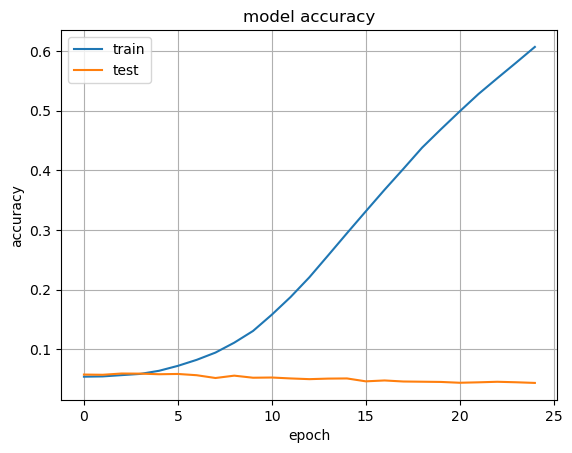

In [34]:
# Оценка и построение графиков
# График правильности модели

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best');
plt.grid()
plt.savefig("05.AccuracyEm_LSTM_RNN.png")
plt.show()

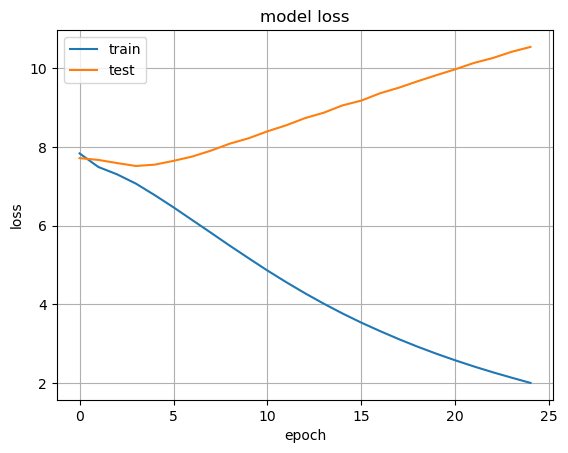

In [35]:
# График потерь

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');
plt.grid()
plt.savefig("06.LossEm_LSTM_RNN.png")
plt.show()

In [36]:
# Изменим функцию для построения фраз

def buildPhrase(texts, str_len=20):
        res = texts
        data = tokenizer.texts_to_sequences([texts])[0]
        for i in range(str_len):
            x = data[i: i + inp_words]
            inp = np.expand_dims(x, axis=0)

            pred = model.predict(inp)
            indx = pred.argmax(axis=1)[0]
            data.append(indx)

            res += " " + tokenizer.index_word[indx]  # дописываем строку

        return res

In [37]:
# Проверим модель используя примеры из датасета

# Язву на воинство злую навел; погибали народы
res = buildPhrase("язву на воинство")
print(res)
# Проверим модель

# Старец, он приходил к кораблям быстролетным ахейским
res = buildPhrase("он приходил к")
print(res)

1/1 [==============================] - 0s 21ms/step
язву на воинство злую навел народы в казнь что ты обесчестил прикажет и ты я надеюсь копьеборцем иль воином венец журавлей убедительно всех
1/1 [==============================] - 0s 22ms/step
он приходил к кораблям быстролетным добыли светлой мы славы повержен царю ахиллес быстроногий сын благородный лаэртов герой одиссей многоумный я ни упреков отнюдь


In [38]:
# Проверим модель используя примеры не из датасета

# знаешь ли ты что такое горе
res = buildPhrase("знаешь ли ты")
print(res)
# Проверим модель ещё раз

# он приходил ко мне во снах
res = buildPhrase("он приходил ко")
print(res)

1/1 [==============================] - 0s 21ms/step
знаешь ли ты и сам как и следует и вы из опасностей брани ежели мне помедли в полдень но не все от бессмертных
1/1 [==============================] - 0s 24ms/step
он приходил ко троянской воинств и когда да как будет мое мне мое благородное сердце алкает брачный совершив как в четвертый раз устремился
